In [2]:
!pip install xlrd

Defaulting to user installation because normal site-packages is not writeable
  Using cached xlrd-2.0.2-py2.py3-none-any.whl (96 kB)


In [3]:
import pandas as pd

# Define columns to read
columns = ['PW(µs)','Azimuth(º)','Elevation(º)','Power(dBm)','Freq(MHz)','Name']

# Import all files
df_1 = pd.read_excel('set1.xls', usecols=columns)
df_2 = pd.read_excel('set2.xls', usecols=columns)
df_3 = pd.read_excel('set3.xlsx', usecols=columns)
df_5 = pd.read_csv('set5.csv', usecols=columns)
df_6 = pd.read_excel('set6.xlsx', usecols=columns)

In [4]:
print(df_1['Name'].value_counts())
print(df_2['Name'].value_counts())
print(df_3['Name'].value_counts())
print(df_5['Name'].value_counts())
print(df_6['Name'].value_counts())



Name
J     16154
S3     3190
S1     2665
S4     2215
F      1487
S2      394
Name: count, dtype: int64
Name
F    1037
A     662
C     550
I     526
B     428
H     372
D     257
G     234
E     205
Name: count, dtype: int64
Name
A    4663
E    4205
F    1037
C     550
I     526
B     428
H     372
D     257
G     234
Name: count, dtype: int64
Name
J     16183
S3     3190
S1     2665
S4     2243
F      1487
S2      394
Name: count, dtype: int64
Name
S1    25262
T      9102
J      8255
S4     5307
F      2002
S3     1861
S2      237
Name: count, dtype: int64


In [9]:
# Concatenate all dataframes vertically
df_combined = pd.concat([df_1, df_2, df_3, df_5, df_6], ignore_index=True)

# Display first few rows of combined dataframe
df_combined.head()

# Optional: check the total number of rows
print(f"Total number of rows: {len(df_combined)}")

Total number of rows: 120836


In [10]:
df_combined['Name'].value_counts()

Name
J     40592
S1    30592
S4     9765
T      9102
S3     8241
F      7050
A      5325
E      4410
C      1100
I      1052
S2     1025
B       856
H       744
D       514
G       468
Name: count, dtype: int64

In [11]:
df_combined.to_csv('CombinedDeinterleaved.csv',index=False)

--- Emitter Classification Training using Siamese Triplet Loss (ANN Version) ---
Loading data from 'CombinedDeinterleaved.csv'...
   Label mapping created:
   0 -> 'S1'
   1 -> 'F'
   2 -> 'S3'
   3 -> 'S2'
   4 -> 'S4'
   5 -> 'J'
   6 -> 'A'
   7 -> 'B'
   8 -> 'C'
   9 -> 'D'
   10 -> 'E'
   11 -> 'G'
   12 -> 'H'
   13 -> 'I'
   14 -> 'T'
   Successfully loaded and processed 120836 pulses.

2. Splitting data into 80% training and 20% testing...
   Training set size: 96668
   Testing set size: 24168

3. Creating Triplet Dataset and DataLoader for training...
4. Initializing model, loss function, and optimizer...
5. Starting training for 200 epochs...
   Epoch [1/200], Average Loss: 0.1672
   Epoch [2/200], Average Loss: 0.0727
   Epoch [3/200], Average Loss: 0.0646
   Epoch [4/200], Average Loss: 0.0533
   Epoch [5/200], Average Loss: 0.0482
   Epoch [6/200], Average Loss: 0.0478
   Epoch [7/200], Average Loss: 0.0432
   Epoch [8/200], Average Loss: 0.0413
   Epoch [9/200], Average 

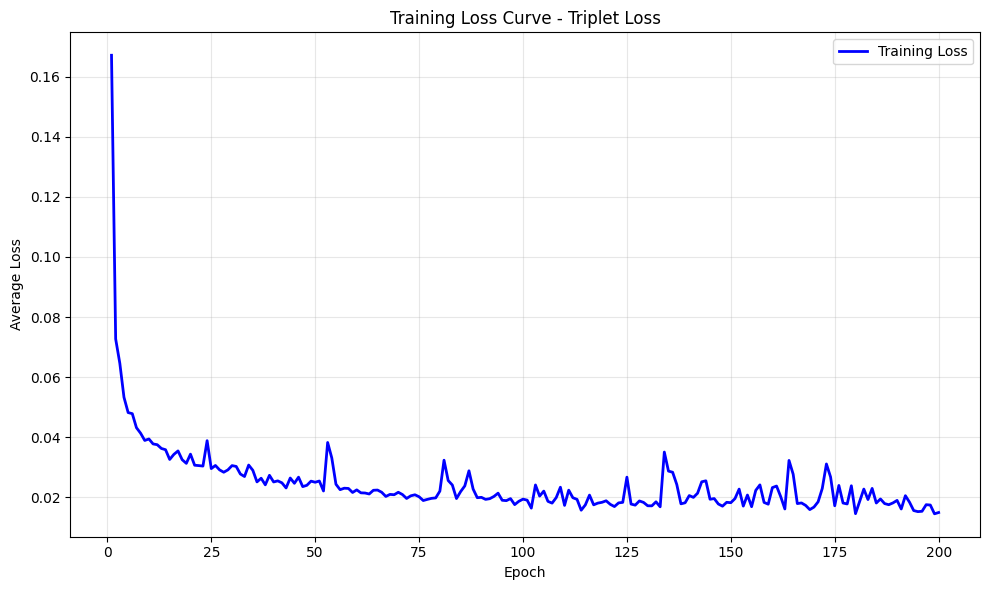


6. Evaluating the model on the test set...

   Overall Accuracy on Test Set: 97.79%

   Classification Report:
              precision    recall  f1-score   support

          S1       0.99      0.97      0.98      6119
           F       0.99      0.96      0.97      1410
          S3       0.88      0.94      0.91      1648
          S2       0.72      0.81      0.76       205
          S4       0.99      0.97      0.98      1953
           J       1.00      1.00      1.00      8119
           A       1.00      0.99      0.99      1065
           B       1.00      1.00      1.00       171
           C       0.69      0.99      0.81       220
           D       0.73      0.90      0.81       103
           E       0.99      0.99      0.99       882
           G       1.00      1.00      1.00        94
           H       1.00      1.00      1.00       149
           I       0.88      0.88      0.88       210
           T       1.00      1.00      1.00      1820

    accuracy          

/home/harshwardhan/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


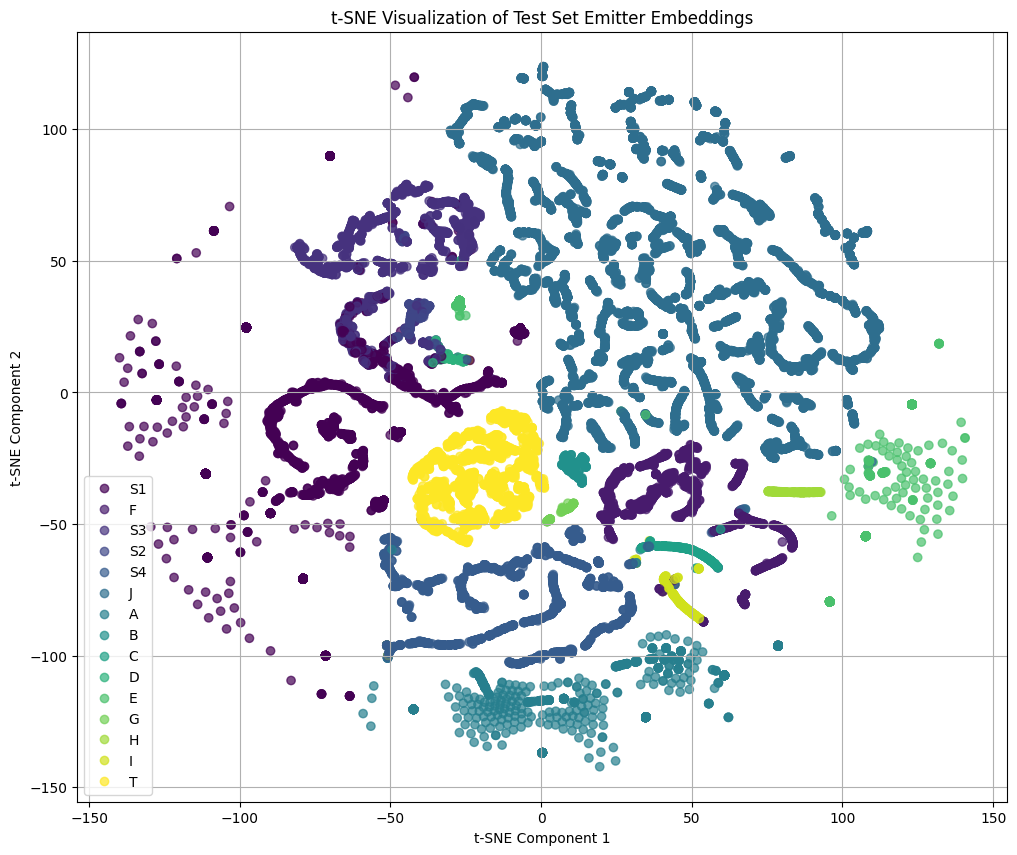

--- Script finished. ---


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from collections import defaultdict
import random
import os

# --- 1. Configuration ---
# You can tune these parameters
EMBEDDING_DIM = 128      # The size of the learned embedding vector
MARGIN = 1.0             # The margin for the Triplet Loss
LEARNING_RATE = 0.003
BATCH_SIZE = 32
EPOCHS = 200
TEST_SPLIT_SIZE = 0.2    # 20% of data will be used for testing

# --- 2. Data Loading and Preprocessing ---
def load_and_preprocess_data(file_path):
    """
    Loads PDW data from a CSV file and preprocesses it.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        tuple: A tuple containing:
            - pdws_normalized (np.ndarray): Normalized array of PDW features.
            - labels_numeric (np.ndarray): Array of numeric labels.
            - label_mapping (dict): A dictionary mapping numeric labels back to original names.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Error: The file '{file_path}' was not found.")
        
    print(f"Loading data from '{file_path}'...")
    df = pd.read_csv(file_path)

    # Define feature and label columns
    feature_columns = ['PW(µs)','Azimuth(º)','Elevation(º)','Power(dBm)','Freq(MHz)']
    label_column = 'Name'

    # Check for required columns
    for col in feature_columns + [label_column]:
        if col not in df.columns:
            raise ValueError(f"Error: CSV file must contain the column '{col}'.")

    # Extract features
    pdws = df[feature_columns].values.astype(np.float32)

    # Convert string labels to numeric labels
    labels_numeric, unique_labels = pd.factorize(df[label_column])
    label_mapping = {i: name for i, name in enumerate(unique_labels)}
    
    print("   Label mapping created:")
    for numeric_label, string_label in label_mapping.items():
        print(f"   {numeric_label} -> '{string_label}'")

    # Normalize all feature columns
    pdws_normalized = np.copy(pdws)
    for col in range(pdws_normalized.shape[1]):
        mean = pdws_normalized[:, col].mean()
        std = pdws_normalized[:, col].std()
        if std > 0:
            pdws_normalized[:, col] = (pdws_normalized[:, col] - mean) / std
    
    print(f"   Successfully loaded and processed {len(df)} pulses.")
    return pdws_normalized, labels_numeric, label_mapping


# --- 3. Triplet Dataset Class ---
# This custom PyTorch Dataset creates triplets of single PDW vectors on-the-fly.
class TripletPDWDataset(Dataset):
    """
    Custom dataset for generating triplets of single PDW vectors.
    """
    def __init__(self, pdws, labels):
        self.pdws = pdws
        self.labels = labels
        
        # Group indices by label for efficient triplet mining
        self.label_to_indices = defaultdict(list)
        for idx, label in enumerate(labels):
            self.label_to_indices[label].append(idx)
        
        self.labels_set = list(self.label_to_indices.keys())
        if len(self.labels_set) < 2:
            raise ValueError("The dataset must contain at least two different classes to create triplets.")

    def __len__(self):
        return len(self.pdws)

    def __getitem__(self, index):
        # --- Anchor Selection ---
        anchor_idx = index
        anchor_label = self.labels[anchor_idx]
        anchor_pdw = torch.FloatTensor(self.pdws[anchor_idx])

        # --- Positive Selection ---
        # Randomly select another sample from the same class
        positive_idx = random.choice(self.label_to_indices[anchor_label])
        positive_pdw = torch.FloatTensor(self.pdws[positive_idx])

        # --- Negative Selection ---
        # Randomly select a sample from a different class
        negative_label = random.choice([l for l in self.labels_set if l != anchor_label])
        negative_idx = random.choice(self.label_to_indices[negative_label])
        negative_pdw = torch.FloatTensor(self.pdws[negative_idx])

        return anchor_pdw, positive_pdw, negative_pdw

# --- 4. Model Architecture (The Encoder f(x)) ---
# An ANN/MLP-based network to process single PDWs and output an embedding.
class EmitterEncoder(nn.Module):
    """
    ANN/MLP-based encoder to generate embeddings from single PDW vectors.
    """
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(EmitterEncoder, self).__init__()
        # A simple multi-layer perceptron
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
        )

    def forward(self, x):
        embedding = self.net(x)
        # Normalize the embedding to have unit length (improves stability)
        embedding = nn.functional.normalize(embedding, p=2, dim=1)
        return embedding

# --- 5. Triplet Loss Function (Removed custom class) ---
# We will now use the built-in PyTorch loss function nn.TripletMarginLoss

# --- 6. Main Execution Block ---
if __name__ == '__main__':
    # !!! IMPORTANT !!!
    # !!! CHANGE THIS PATH TO POINT TO YOUR CSV FILE !!!
    # CSV_FILE_PATH = 'sampledpoints.csv' 
    CSV_FILE_PATH = 'CombinedDeinterleaved.csv' 
    
    print("--- Emitter Classification Training using Siamese Triplet Loss (ANN Version) ---")

   
    pdws, labels, label_mapping = load_and_preprocess_data(CSV_FILE_PATH)
    # Step 2: Split data into Training and Testing sets
    print(f"\n2. Splitting data into {1-TEST_SPLIT_SIZE:.0%} training and {TEST_SPLIT_SIZE:.0%} testing...")
    X_train, X_test, y_train, y_test = train_test_split(
        pdws, labels, test_size=TEST_SPLIT_SIZE, random_state=42, stratify=labels
    )
    print(f"   Training set size: {len(X_train)}")
    print(f"   Testing set size: {len(X_test)}")

    # Step 3: Create Dataset and DataLoader for TRAINING data
    print("\n3. Creating Triplet Dataset and DataLoader for training...")
    train_dataset = TripletPDWDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Step 4: Initialize Model, Loss, and Optimizer
    print("4. Initializing model, loss function, and optimizer...")
    input_dim = pdws.shape[1] 
    model = EmitterEncoder(input_dim=input_dim, hidden_dim=128, embedding_dim=EMBEDDING_DIM)
    
    # *** CHANGE: Use the built-in PyTorch TripletMarginLoss ***
    criterion = nn.TripletMarginLoss(margin=MARGIN)
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Step 5: Training Loop with Loss Tracking
    print(f"5. Starting training for {EPOCHS} epochs...")
    model.train()
    
    # Initialize loss tracking
    epoch_losses = []
    
    for epoch in range(EPOCHS):
        total_loss = 0
        for i, (anchor, positive, negative) in enumerate(train_dataloader):
            optimizer.zero_grad()
            anchor_emb, positive_emb, negative_emb = model(anchor), model(positive), model(negative)
            
            # The call to the criterion remains the same
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_dataloader)
        epoch_losses.append(avg_loss)
        print(f"   Epoch [{epoch+1}/{EPOCHS}], Average Loss: {avg_loss:.4f}")

    print("--- Training complete! ---")

    # Step 5.5: Plot Loss Curve
    print("\n5.5. Plotting training loss curve...")
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, EPOCHS + 1), epoch_losses, 'b-', linewidth=2, label='Training Loss')
    plt.title('Training Loss Curve - Triplet Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Step 6: Evaluation
    print("\n6. Evaluating the model on the test set...")
    model.eval()
    with torch.no_grad():
        # A: Generate embeddings for the entire training set to define cluster centroids
        train_embeddings = model(torch.FloatTensor(X_train)).numpy()
        
        # B: Calculate the centroid for each cluster from the training data
        cluster_centroids = defaultdict(list)
        for i, label in enumerate(y_train):
            cluster_centroids[label].append(train_embeddings[i])
        
        for label in cluster_centroids:
            cluster_centroids[label] = np.mean(cluster_centroids[label], axis=0)
            
        # C: Generate embeddings for the test set
        test_embeddings = model(torch.FloatTensor(X_test)).numpy()
        
        # D: Predict the label for each test embedding by finding the closest centroid
        predictions = []
        for test_emb in test_embeddings:
            distances = {label: np.linalg.norm(test_emb - centroid) for label, centroid in cluster_centroids.items()}
            predicted_label = min(distances, key=distances.get)
            predictions.append(predicted_label)
            
        # E: Calculate and print accuracy and classification report
        accuracy = accuracy_score(y_test, predictions)
        print(f"\n   Overall Accuracy on Test Set: {accuracy * 100:.2f}%")
        
        report_labels = sorted(list(label_mapping.keys()))
        report_target_names = [label_mapping[lbl] for lbl in report_labels]
        print("\n   Classification Report:")
        print(classification_report(y_test, predictions, labels=report_labels, target_names=report_target_names))


    # Step 7: Visualization of TEST SET embeddings
    print("\n7. Visualizing the learned embedding space for the TEST SET using t-SNE...")
    # Use t-SNE to reduce dimensionality of test embeddings to 2D for plotting
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_test)-1), n_iter=1000)
    embeddings_2d = tsne.fit_transform(test_embeddings)

    # Plot the results
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, cmap='viridis', alpha=0.7)
    plt.title('t-SNE Visualization of Test Set Emitter Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    
    legend_labels = [label_mapping[i] for i in sorted(label_mapping.keys())]
    plt.legend(handles=scatter.legend_elements(num=len(legend_labels))[0], labels=legend_labels)
    plt.grid(True)
    plt.show()

    print("--- Script finished. ---")


--- Emitter Classification Training using Siamese Triplet Loss (ANN Version) ---
Loading data from 'CombinedDeinterleaved.csv'...
   Label mapping created:
   0 -> 'S1'
   1 -> 'F'
   2 -> 'S3'
   3 -> 'S2'
   4 -> 'S4'
   5 -> 'J'
   6 -> 'A'
   7 -> 'B'
   8 -> 'C'
   9 -> 'D'
   10 -> 'E'
   11 -> 'G'
   12 -> 'H'
   13 -> 'I'
   14 -> 'T'
   Successfully loaded and processed 120836 pulses.

2. Splitting data into 80% training and 20% testing...
   Training set size: 96668
   Testing set size: 24168

3. Creating Triplet Dataset and DataLoader for training...
4. Initializing model, loss function, and optimizer...
5. Starting training for 200 epochs...
   Epoch [1/200], Average Loss: 0.1501
   Epoch [2/200], Average Loss: 0.0702
   Epoch [3/200], Average Loss: 0.0555
   Epoch [4/200], Average Loss: 0.0498
   Epoch [5/200], Average Loss: 0.0458
   Epoch [6/200], Average Loss: 0.0447
   Epoch [7/200], Average Loss: 0.0428
   Epoch [8/200], Average Loss: 0.0396
   Epoch [9/200], Average 

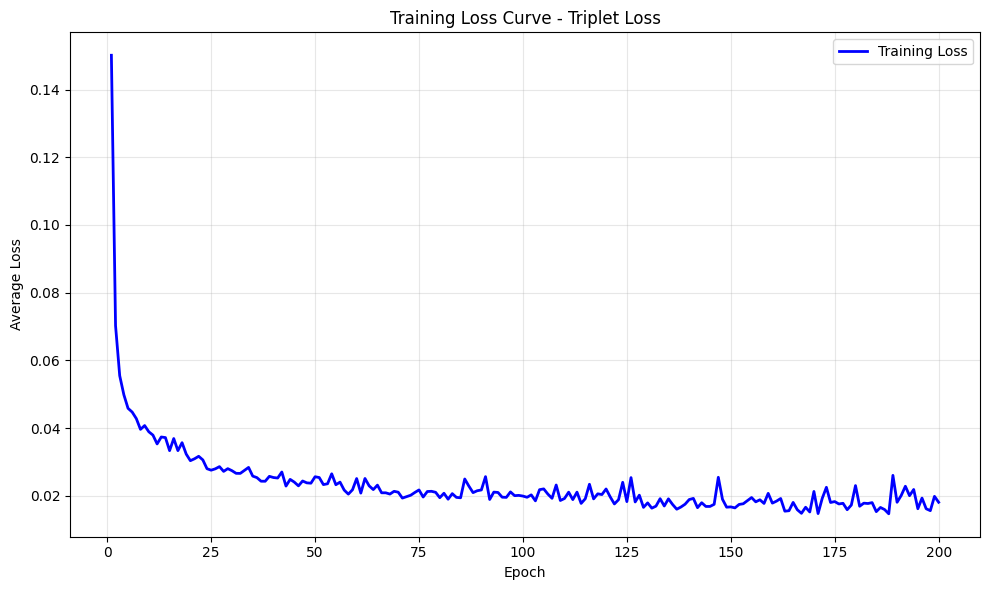


6. Evaluating the model on the test set using Mahalanobis distance...
   Calculating class distributions (mean and covariance)...

   Overall Accuracy on Test Set: 98.05%

   Classification Report:
              precision    recall  f1-score   support

          S1       1.00      0.96      0.98      6119
           F       0.98      1.00      0.99      1410
          S3       0.88      0.92      0.90      1648
          S2       0.63      0.94      0.75       205
          S4       0.99      0.99      0.99      1953
           J       1.00      1.00      1.00      8119
           A       0.99      0.99      0.99      1065
           B       1.00      1.00      1.00       171
           C       1.00      0.99      1.00       220
           D       0.64      0.98      0.77       103
           E       0.97      1.00      0.98       882
           G       1.00      1.00      1.00        94
           H       1.00      1.00      1.00       149
           I       1.00      0.99      0.99 

/home/harshwardhan/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


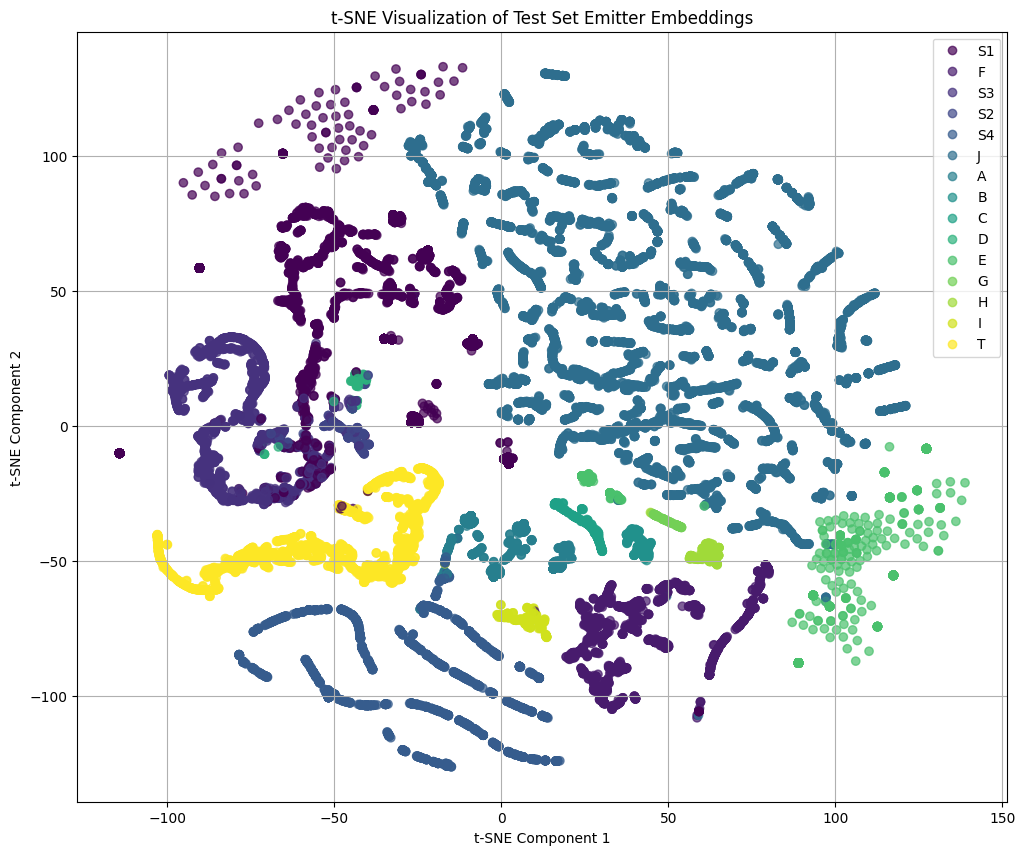

--- Script finished. ---


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from collections import defaultdict
import random
import os
from scipy.spatial.distance import mahalanobis

# --- 1. Configuration ---
# You can tune these parameters
EMBEDDING_DIM = 128      # The size of the learned embedding vector
MARGIN = 1.0             # The margin for the Triplet Loss
LEARNING_RATE = 0.003
BATCH_SIZE = 32
EPOCHS = 200
TEST_SPLIT_SIZE = 0.2    # 20% of data will be used for testing

# --- 2. Data Loading and Preprocessing ---
def load_and_preprocess_data(file_path):
    """
    Loads PDW data from a CSV file and preprocesses it.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        tuple: A tuple containing:
            - pdws_normalized (np.ndarray): Normalized array of PDW features.
            - labels_numeric (np.ndarray): Array of numeric labels.
            - label_mapping (dict): A dictionary mapping numeric labels back to original names.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Error: The file '{file_path}' was not found.")
        
    print(f"Loading data from '{file_path}'...")
    df = pd.read_csv(file_path)

    # Define feature and label columns
    feature_columns = ['PW(µs)','Azimuth(º)','Elevation(º)','Power(dBm)','Freq(MHz)']
    label_column = 'Name'

    # Check for required columns
    for col in feature_columns + [label_column]:
        if col not in df.columns:
            raise ValueError(f"Error: CSV file must contain the column '{col}'.")

    # Extract features
    pdws = df[feature_columns].values.astype(np.float32)

    # Convert string labels to numeric labels
    labels_numeric, unique_labels = pd.factorize(df[label_column])
    label_mapping = {i: name for i, name in enumerate(unique_labels)}
    
    print("   Label mapping created:")
    for numeric_label, string_label in label_mapping.items():
        print(f"   {numeric_label} -> '{string_label}'")

    # Normalize all feature columns
    pdws_normalized = np.copy(pdws)
    for col in range(pdws_normalized.shape[1]):
        mean = pdws_normalized[:, col].mean()
        std = pdws_normalized[:, col].std()
        if std > 0:
            pdws_normalized[:, col] = (pdws_normalized[:, col] - mean) / std
    
    print(f"   Successfully loaded and processed {len(df)} pulses.")
    return pdws_normalized, labels_numeric, label_mapping


# --- 3. Triplet Dataset Class ---
# This custom PyTorch Dataset creates triplets of single PDW vectors on-the-fly.
class TripletPDWDataset(Dataset):
    """
    Custom dataset for generating triplets of single PDW vectors.
    """
    def __init__(self, pdws, labels):
        self.pdws = pdws
        self.labels = labels
        
        # Group indices by label for efficient triplet mining
        self.label_to_indices = defaultdict(list)
        for idx, label in enumerate(labels):
            self.label_to_indices[label].append(idx)
        
        self.labels_set = list(self.label_to_indices.keys())
        if len(self.labels_set) < 2:
            raise ValueError("The dataset must contain at least two different classes to create triplets.")

    def __len__(self):
        return len(self.pdws)

    def __getitem__(self, index):
        # --- Anchor Selection ---
        anchor_idx = index
        anchor_label = self.labels[anchor_idx]
        anchor_pdw = torch.FloatTensor(self.pdws[anchor_idx])

        # --- Positive Selection ---
        # Randomly select another sample from the same class
        positive_idx = random.choice(self.label_to_indices[anchor_label])
        positive_pdw = torch.FloatTensor(self.pdws[positive_idx])

        # --- Negative Selection ---
        # Randomly select a sample from a different class
        negative_label = random.choice([l for l in self.labels_set if l != anchor_label])
        negative_idx = random.choice(self.label_to_indices[negative_label])
        negative_pdw = torch.FloatTensor(self.pdws[negative_idx])

        return anchor_pdw, positive_pdw, negative_pdw

# --- 4. Model Architecture (The Encoder f(x)) ---
# An ANN/MLP-based network to process single PDWs and output an embedding.
class EmitterEncoder(nn.Module):
    """
    ANN/MLP-based encoder to generate embeddings from single PDW vectors.
    """
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(EmitterEncoder, self).__init__()
        # A simple multi-layer perceptron
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
        )

    def forward(self, x):
        embedding = self.net(x)
        # Normalize the embedding to have unit length (improves stability)
        embedding = nn.functional.normalize(embedding, p=2, dim=1)
        return embedding

# --- 5. Triplet Loss Function (Removed custom class) ---
# We will now use the built-in PyTorch loss function nn.TripletMarginLoss

# --- 6. Main Execution Block ---
if __name__ == '__main__':
    # !!! IMPORTANT !!!
    # !!! CHANGE THIS PATH TO POINT TO YOUR CSV FILE !!!
    # CSV_FILE_PATH = 'sampledpoints.csv' 
    CSV_FILE_PATH = 'CombinedDeinterleaved.csv' 
    
    print("--- Emitter Classification Training using Siamese Triplet Loss (ANN Version) ---")

    # Step 1: Load and Preprocess Data
    try:
        pdws, labels, label_mapping = load_and_preprocess_data(CSV_FILE_PATH)
    except (FileNotFoundError, ValueError) as e:
        print(e)
        # Create a dummy CSV file for demonstration if the specified one doesn't exist
        print(f"\nCreating a dummy file '{CSV_FILE_PATH}' for demonstration purposes.")
        print("Please replace this with your actual data file.")
        dummy_data = {
            'PW(µs)': np.random.rand(1000) * 10,
            'Azimuth(º)': np.random.rand(1000) * 360,
            'Elevation(º)': np.random.rand(1000) * 90,
            'Power(dBm)': -50 + np.random.rand(1000) * 20,
            'Freq(MHz)': 8000 + np.random.rand(1000) * 2000,
            'Name': [random.choice(['Emitter_A', 'Emitter_B', 'Emitter_C']) for _ in range(1000)]
        }
        pd.DataFrame(dummy_data).to_csv(CSV_FILE_PATH, index=False)
        pdws, labels, label_mapping = load_and_preprocess_data(CSV_FILE_PATH)

    # Step 2: Split data into Training and Testing sets
    print(f"\n2. Splitting data into {1-TEST_SPLIT_SIZE:.0%} training and {TEST_SPLIT_SIZE:.0%} testing...")
    X_train, X_test, y_train, y_test = train_test_split(
        pdws, labels, test_size=TEST_SPLIT_SIZE, random_state=42, stratify=labels
    )
    print(f"   Training set size: {len(X_train)}")
    print(f"   Testing set size: {len(X_test)}")

    # Step 3: Create Dataset and DataLoader for TRAINING data
    print("\n3. Creating Triplet Dataset and DataLoader for training...")
    train_dataset = TripletPDWDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Step 4: Initialize Model, Loss, and Optimizer
    print("4. Initializing model, loss function, and optimizer...")
    input_dim = pdws.shape[1] 
    model = EmitterEncoder(input_dim=input_dim, hidden_dim=128, embedding_dim=EMBEDDING_DIM)
    
    criterion = nn.TripletMarginLoss(margin=MARGIN)
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Step 5: Training Loop with Loss Tracking
    print(f"5. Starting training for {EPOCHS} epochs...")
    model.train()
    
    epoch_losses = []
    
    for epoch in range(EPOCHS):
        total_loss = 0
        for i, (anchor, positive, negative) in enumerate(train_dataloader):
            optimizer.zero_grad()
            anchor_emb, positive_emb, negative_emb = model(anchor), model(positive), model(negative)
            
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_dataloader)
        epoch_losses.append(avg_loss)
        print(f"   Epoch [{epoch+1}/{EPOCHS}], Average Loss: {avg_loss:.4f}")

    print("--- Training complete! ---")

    # Step 5.5: Plot Loss Curve
    print("\n5.5. Plotting training loss curve...")
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, EPOCHS + 1), epoch_losses, 'b-', linewidth=2, label='Training Loss')
    plt.title('Training Loss Curve - Triplet Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Step 6: Evaluation using Mahalanobis Distance ---
    print("\n6. Evaluating the model on the test set using Mahalanobis distance...")
    model.eval()
    with torch.no_grad():
        # A: Generate embeddings for the entire training set
        train_embeddings = model(torch.FloatTensor(X_train)).numpy()
        
        # B: Calculate the mean and inverse covariance matrix for each class distribution
        print("   Calculating class distributions (mean and covariance)...")
        class_distributions = {}
        for label in np.unique(y_train):
            # Get all embeddings for the current class
            class_embeddings = train_embeddings[y_train == label]
            
            # Calculate mean (centroid)
            mean_vec = np.mean(class_embeddings, axis=0)
            
            # Calculate covariance matrix
            # Add a small regularization term (identity matrix) for numerical stability before inverting
            cov = np.cov(class_embeddings, rowvar=False)
            reg_cov = cov + np.eye(class_embeddings.shape[1]) * 1e-6
            
            # Calculate the inverse of the regularized covariance matrix
            inv_cov = np.linalg.inv(reg_cov)
            
            # Store the distribution parameters
            class_distributions[label] = {'mean': mean_vec, 'inv_cov': inv_cov}
            
        # C: Generate embeddings for the test set
        test_embeddings = model(torch.FloatTensor(X_test)).numpy()
        
        # D: Predict the label for each test embedding by finding the minimum Mahalanobis distance
        predictions = []
        for test_emb in test_embeddings:
            distances = {}
            for label, dist_params in class_distributions.items():
                # Using scipy's mahalanobis distance which takes the inverse covariance matrix
                distances[label] = mahalanobis(test_emb, dist_params['mean'], dist_params['inv_cov'])
            
            predicted_label = min(distances, key=distances.get)
            predictions.append(predicted_label)
            
        # E: Calculate and print accuracy and classification report
        accuracy = accuracy_score(y_test, predictions)
        print(f"\n   Overall Accuracy on Test Set: {accuracy * 100:.2f}%")
        
        report_labels = sorted(list(label_mapping.keys()))
        report_target_names = [label_mapping[lbl] for lbl in report_labels]
        print("\n   Classification Report:")
        print(classification_report(y_test, predictions, labels=report_labels, target_names=report_target_names))


    # Step 7: Visualization of TEST SET embeddings
    print("\n7. Visualizing the learned embedding space for the TEST SET using t-SNE...")
    # Use t-SNE to reduce dimensionality of test embeddings to 2D for plotting
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_test)-1), n_iter=1000)
    embeddings_2d = tsne.fit_transform(test_embeddings)

    # Plot the results
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, cmap='viridis', alpha=0.7)
    plt.title('t-SNE Visualization of Test Set Emitter Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    
    legend_labels = [label_mapping[i] for i in sorted(label_mapping.keys())]
    plt.legend(handles=scatter.legend_elements(num=len(legend_labels))[0], labels=legend_labels)
    plt.grid(True)
    plt.show()

    print("--- Script finished. ---")


### Experiment to directly cluster the embeddings

--- Emitter Classification Training using Siamese Triplet Loss (ANN Version) ---
Loading data from 'CombinedDeinterleaved.csv'...
   Label mapping created:
   0 -> 'S1'
   1 -> 'F'
   2 -> 'S3'
   3 -> 'S2'
   4 -> 'S4'
   5 -> 'J'
   6 -> 'A'
   7 -> 'B'
   8 -> 'C'
   9 -> 'D'
   10 -> 'E'
   11 -> 'G'
   12 -> 'H'
   13 -> 'I'
   14 -> 'T'
   Successfully loaded and processed 120836 pulses.

5. Starting training for 200 epochs...
   Epoch [10/200], Average Loss: 0.0366
   Epoch [20/200], Average Loss: 0.0286
   Epoch [30/200], Average Loss: 0.0264
   Epoch [40/200], Average Loss: 0.0224
   Epoch [50/200], Average Loss: 0.0229
   Epoch [60/200], Average Loss: 0.0200
   Epoch [70/200], Average Loss: 0.0185
   Epoch [80/200], Average Loss: 0.0184
   Epoch [90/200], Average Loss: 0.0181
   Epoch [100/200], Average Loss: 0.0186
   Epoch [110/200], Average Loss: 0.0228
   Epoch [120/200], Average Loss: 0.0186
   Epoch [130/200], Average Loss: 0.0169
   Epoch [140/200], Average Loss: 0.017

/home/harshwardhan/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


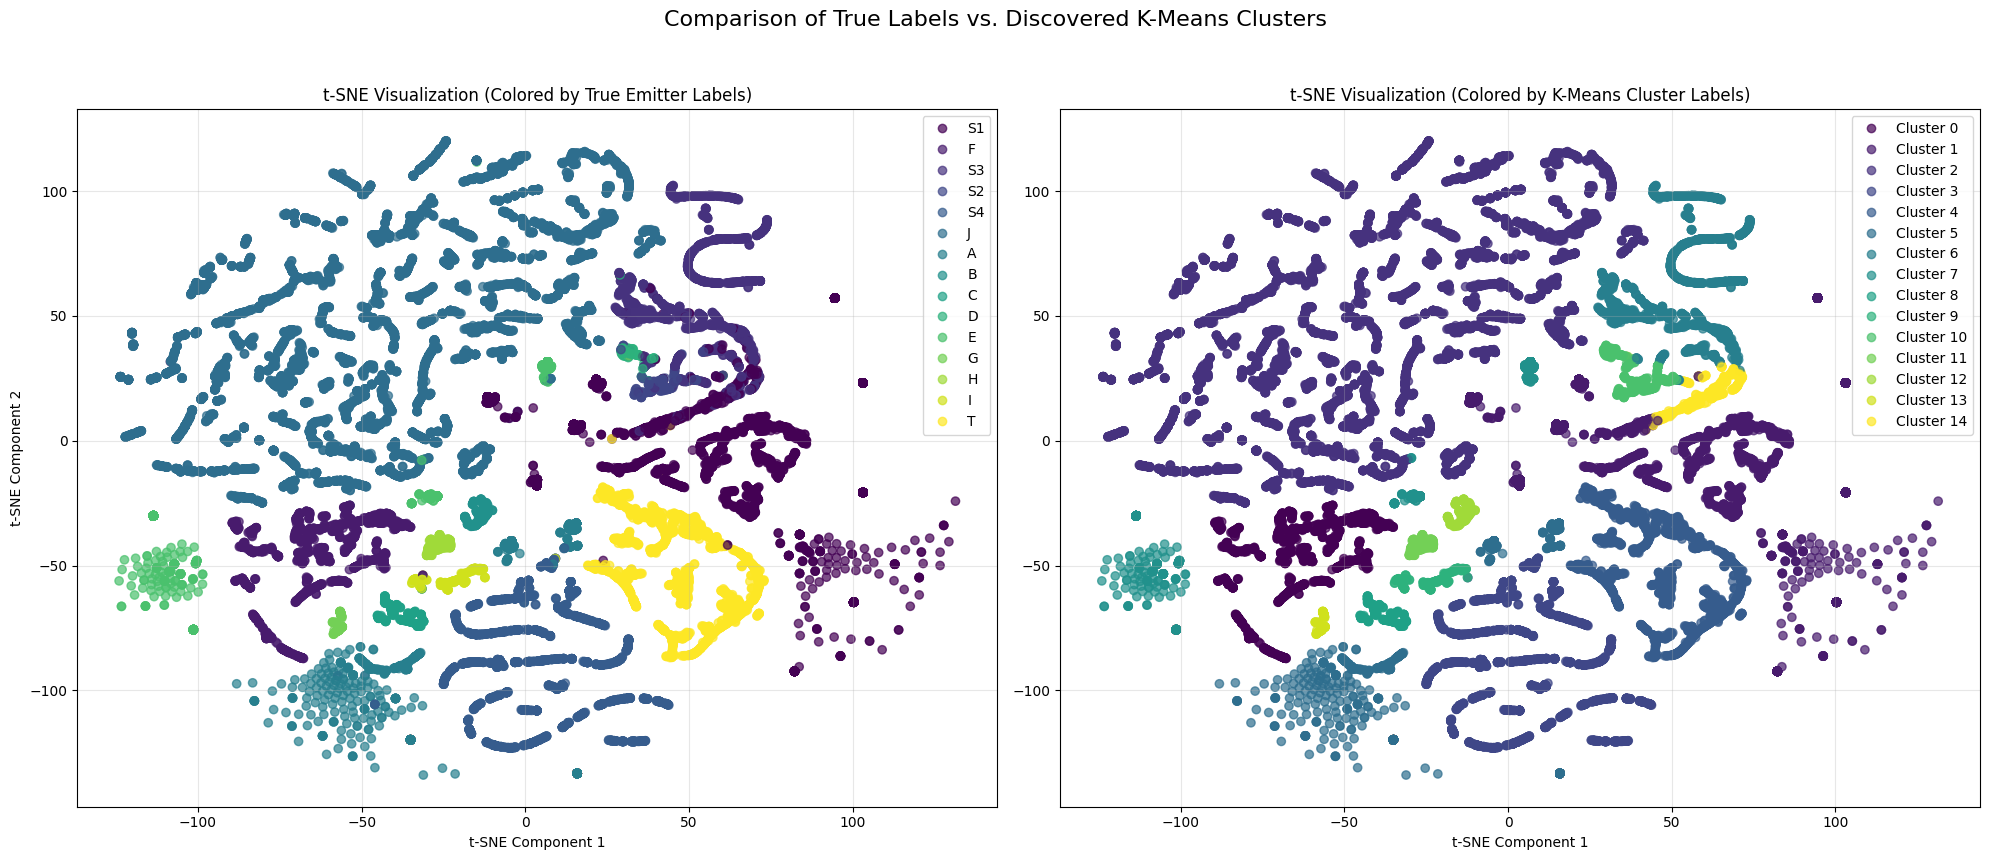

--- Script finished. ---


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, v_measure_score
from sklearn.cluster import KMeans
from collections import defaultdict
import random
import os
from scipy.spatial.distance import mahalanobis

# --- 1. Configuration ---
# You can tune these parameters
EMBEDDING_DIM = 128      # The size of the learned embedding vector
MARGIN = 1.0             # The margin for the Triplet Loss
LEARNING_RATE = 0.003
BATCH_SIZE = 32
EPOCHS = 200
TEST_SPLIT_SIZE = 0.2    # 20% of data will be used for testing

# --- 2. Data Loading and Preprocessing ---
def load_and_preprocess_data(file_path):
    """
    Loads PDW data from a CSV file and preprocesses it.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        tuple: A tuple containing:
            - pdws_normalized (np.ndarray): Normalized array of PDW features.
            - labels_numeric (np.ndarray): Array of numeric labels.
            - label_mapping (dict): A dictionary mapping numeric labels back to original names.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Error: The file '{file_path}' was not found.")
        
    print(f"Loading data from '{file_path}'...")
    df = pd.read_csv(file_path)

    # Define feature and label columns
    feature_columns = ['PW(µs)','Azimuth(º)','Elevation(º)','Power(dBm)','Freq(MHz)']
    label_column = 'Name'

    # Check for required columns
    for col in feature_columns + [label_column]:
        if col not in df.columns:
            raise ValueError(f"Error: CSV file must contain the column '{col}'.")

    # Extract features
    pdws = df[feature_columns].values.astype(np.float32)

    # Convert string labels to numeric labels
    labels_numeric, unique_labels = pd.factorize(df[label_column])
    label_mapping = {i: name for i, name in enumerate(unique_labels)}
    
    print("   Label mapping created:")
    for numeric_label, string_label in label_mapping.items():
        print(f"   {numeric_label} -> '{string_label}'")

    # Normalize all feature columns
    pdws_normalized = np.copy(pdws)
    for col in range(pdws_normalized.shape[1]):
        mean = pdws_normalized[:, col].mean()
        std = pdws_normalized[:, col].std()
        if std > 0:
            pdws_normalized[:, col] = (pdws_normalized[:, col] - mean) / std
    
    print(f"   Successfully loaded and processed {len(df)} pulses.")
    return pdws_normalized, labels_numeric, label_mapping


# --- 3. Triplet Dataset Class ---
class TripletPDWDataset(Dataset):
    """
    Custom dataset for generating triplets of single PDW vectors.
    """
    def __init__(self, pdws, labels):
        self.pdws = pdws
        self.labels = labels
        
        self.label_to_indices = defaultdict(list)
        for idx, label in enumerate(labels):
            self.label_to_indices[label].append(idx)
        
        self.labels_set = list(self.label_to_indices.keys())
        if len(self.labels_set) < 2:
            raise ValueError("The dataset must contain at least two different classes to create triplets.")

    def __len__(self):
        return len(self.pdws)

    def __getitem__(self, index):
        anchor_idx = index
        anchor_label = self.labels[anchor_idx]
        anchor_pdw = torch.FloatTensor(self.pdws[anchor_idx])

        positive_idx = random.choice(self.label_to_indices[anchor_label])
        positive_pdw = torch.FloatTensor(self.pdws[positive_idx])

        negative_label = random.choice([l for l in self.labels_set if l != anchor_label])
        negative_idx = random.choice(self.label_to_indices[negative_label])
        negative_pdw = torch.FloatTensor(self.pdws[negative_idx])

        return anchor_pdw, positive_pdw, negative_pdw

# --- 4. Model Architecture (The Encoder f(x)) ---
class EmitterEncoder(nn.Module):
    """
    ANN/MLP-based encoder to generate embeddings from single PDW vectors.
    """
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(EmitterEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
        )

    def forward(self, x):
        embedding = self.net(x)
        embedding = nn.functional.normalize(embedding, p=2, dim=1)
        return embedding

# --- 6. Main Execution Block ---
if __name__ == '__main__':
    CSV_FILE_PATH = 'CombinedDeinterleaved.csv' 
    
    print("--- Emitter Classification Training using Siamese Triplet Loss (ANN Version) ---")

    # Step 1: Load and Preprocess Data
    try:
        pdws, labels, label_mapping = load_and_preprocess_data(CSV_FILE_PATH)
    except (FileNotFoundError, ValueError) as e:
        print(e)
        print(f"\nCreating a dummy file '{CSV_FILE_PATH}' for demonstration purposes.")
        dummy_data = {
            'PW(µs)': np.random.rand(1000) * 10,
            'Azimuth(º)': np.random.rand(1000) * 360,
            'Elevation(º)': np.random.rand(1000) * 90,
            'Power(dBm)': -50 + np.random.rand(1000) * 20,
            'Freq(MHz)': 8000 + np.random.rand(1000) * 2000,
            'Name': [random.choice(['Emitter_A', 'Emitter_B', 'Emitter_C']) for _ in range(1000)]
        }
        pd.DataFrame(dummy_data).to_csv(CSV_FILE_PATH, index=False)
        pdws, labels, label_mapping = load_and_preprocess_data(CSV_FILE_PATH)

    # Step 2: Split data into Training and Testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        pdws, labels, test_size=TEST_SPLIT_SIZE, random_state=42, stratify=labels
    )

    # Step 3: Create Dataset and DataLoader for TRAINING data
    train_dataset = TripletPDWDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Step 4: Initialize Model, Loss, and Optimizer
    input_dim = pdws.shape[1] 
    model = EmitterEncoder(input_dim=input_dim, hidden_dim=128, embedding_dim=EMBEDDING_DIM)
    criterion = nn.TripletMarginLoss(margin=MARGIN)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Step 5: Training Loop
    print(f"\n5. Starting training for {EPOCHS} epochs...")
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for i, (anchor, positive, negative) in enumerate(train_dataloader):
            optimizer.zero_grad()
            anchor_emb, positive_emb, negative_emb = model(anchor), model(positive), model(negative)
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_dataloader)
        if (epoch + 1) % 10 == 0:
            print(f"   Epoch [{epoch+1}/{EPOCHS}], Average Loss: {avg_loss:.4f}")
    print("--- Training complete! ---")

    # Step 6: Generate Test Embeddings
    print("\n6. Generating embeddings for the test set...")
    model.eval()
    with torch.no_grad():
        test_embeddings = model(torch.FloatTensor(X_test)).numpy()

    # --- Step 7: EXPERIMENT - Unsupervised Clustering Evaluation ---
    print("\n7. EXPERIMENT: Evaluating embedding quality with K-Means clustering...")
    
    # A: Determine the number of clusters (should be the number of unique emitters)
    n_clusters = len(np.unique(y_test))
    print(f"   Running K-Means to find {n_clusters} clusters...")
    
    # B: Run K-Means on the test embeddings
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(test_embeddings)
    
    # C: Evaluate the clustering quality against the true labels
    ari = adjusted_rand_score(y_test, cluster_labels)
    nmi = normalized_mutual_info_score(y_test, cluster_labels)
    v_measure = v_measure_score(y_test, cluster_labels)
    
    print("\n--- Clustering Evaluation Results ---")
    print(f"   Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"   Normalized Mutual Information (NMI): {nmi:.4f}")
    print(f"   V-Measure: {v_measure:.4f}")
    print("   (Scores closer to 1.0 indicate better clustering that aligns with true labels)")
    print("------------------------------------")

    # Step 8: Visualization
    print("\n8. Visualizing the embedding space using t-SNE...")
    
    # Reduce dimensionality for plotting
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_test)-1), n_iter=1000)
    embeddings_2d = tsne.fit_transform(test_embeddings)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))

    # Plot 1: Colored by TRUE labels
    scatter1 = ax1.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, cmap='viridis', alpha=0.7)
    ax1.set_title('t-SNE Visualization (Colored by True Emitter Labels)')
    ax1.set_xlabel('t-SNE Component 1')
    ax1.set_ylabel('t-SNE Component 2')
    legend_labels = [label_mapping[i] for i in sorted(label_mapping.keys())]
    ax1.legend(handles=scatter1.legend_elements(num=len(legend_labels))[0], labels=legend_labels)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Colored by K-MEANS cluster labels
    scatter2 = ax2.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
    ax2.set_title('t-SNE Visualization (Colored by K-Means Cluster Labels)')
    ax2.set_xlabel('t-SNE Component 1')
    # ax2.set_ylabel('t-SNE Component 2') # Optional: remove for cleaner look
    
    # Create a legend for K-Means clusters
    cluster_legend_labels = [f'Cluster {i}' for i in range(n_clusters)]
    ax2.legend(handles=scatter2.legend_elements(num=n_clusters)[0], labels=cluster_legend_labels)
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Comparison of True Labels vs. Discovered K-Means Clusters', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print("--- Script finished. ---")


In [5]:
torch.save(model.state_dict(), 'trained_model_full.pth')

### Inference on unknown set

In [7]:
import pickle
MODEL_SAVE_PATH = "trained_model_full.pth"
STATS_SAVE_PATH = "normalization_stats.pkl"
print("\n\n--- PHASE 2: Running Inference on Unlabeled Data ---")
feature_columns = ['PW(µs)','Azimuth(º)','Elevation(º)','Power(dBm)','Freq(MHz)']
# Step 1: Initialize a new model instance for inference
print("1. Initializing a new model for inference...")
inference_model = EmitterEncoder(input_dim=len(feature_columns), hidden_dim=128, embedding_dim=EMBEDDING_DIM)

# Step 2: Load the saved weights
inference_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
inference_model.eval() # Set to evaluation mode
print("   Successfully loaded trained weights.")

df=pd.read_csv("CombinedDeinterleaved.csv")
### Normalisation stats
pdws = df[feature_columns].values.astype(np.float32)
labels_numeric, _ = pd.factorize(df['Name'])

# Step 2: Normalize data and SAVE the normalization stats
print("2. Normalizing data and saving stats for later use...")
pdws_normalized = np.copy(pdws)
normalization_stats = {'mean': {}, 'std': {}}
for col in range(pdws_normalized.shape[1]):
    mean = pdws_normalized[:, col].mean()
    std = pdws_normalized[:, col].std()
    normalization_stats['mean'][col] = mean
    normalization_stats['std'][col] = std
    if std > 0:
        pdws_normalized[:, col] = (pdws_normalized[:, col] - mean) / std

with open(STATS_SAVE_PATH, 'wb') as f:
    pickle.dump(normalization_stats, f)
print(f"   Normalization stats saved to '{STATS_SAVE_PATH}'")



--- PHASE 2: Running Inference on Unlabeled Data ---
1. Initializing a new model for inference...
   Successfully loaded trained weights.
2. Normalizing data and saving stats for later use...
   Normalization stats saved to 'normalization_stats.pkl'


In [9]:
with open(STATS_SAVE_PATH, 'rb') as f:
    loaded_stats = pickle.load(f)
print("   Loaded normalization stats from training phase.")


unlabeled_pdws=pd.read_csv("Set4.csv")
unlabeled_pdws=unlabeled_pdws[feature_columns]
# Step 4: Normalize the new data using the LOADED stats
unlabeled_pdws_normalized = np.copy(unlabeled_pdws)
for col in range(unlabeled_pdws_normalized.shape[1]):
    mean = loaded_stats['mean'][col]
    std = loaded_stats['std'][col]
    if std > 0:
        unlabeled_pdws_normalized[:, col] = (unlabeled_pdws_normalized[:, col] - mean) / std

# Step 5: Generate embeddings for the unlabeled data
print("3. Generating embeddings for the new data...")
with torch.no_grad():
    unlabeled_embeddings = inference_model(torch.FloatTensor(unlabeled_pdws_normalized)).numpy()

   Loaded normalization stats from training phase.
3. Generating embeddings for the new data...


4. Running K-Means to find 9 clusters...
5. Visualizing the embedding space...


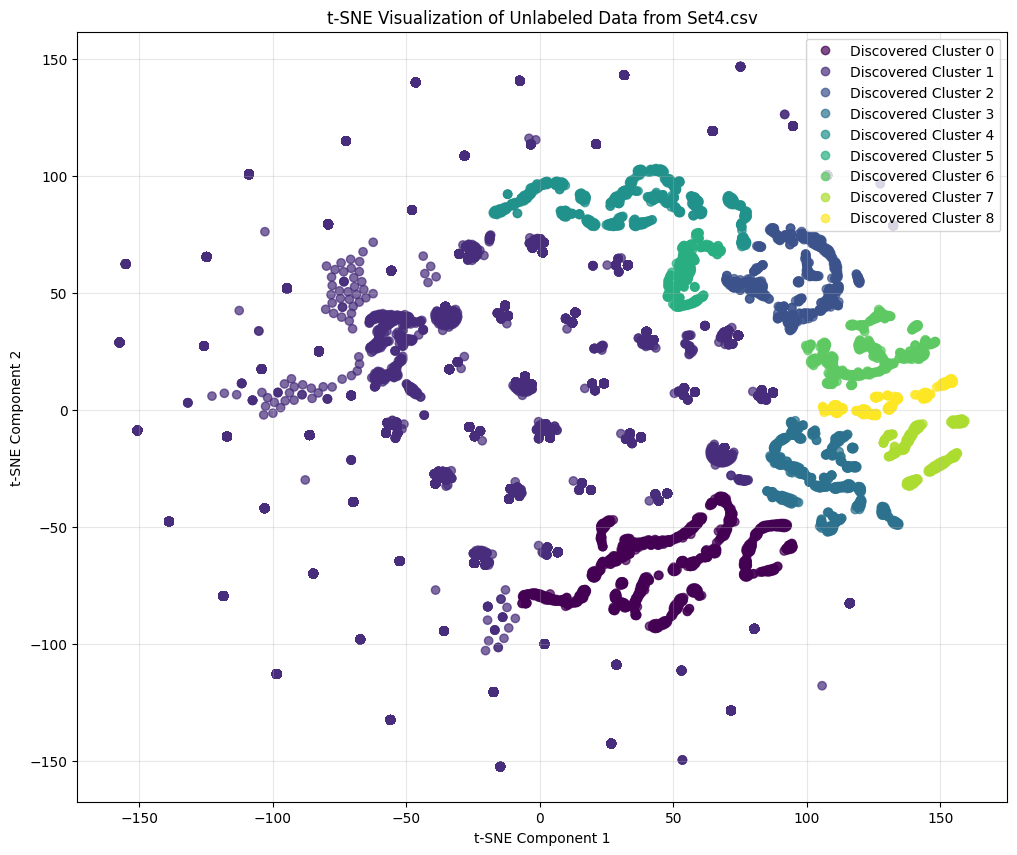


--- Experiment Finished ---


In [10]:
# Step 6: Cluster the embeddings to find the 9 known emitter types
N_CLUSTERS = 9
UNLABELED_DATA_PATH='Set4.csv'
print(f"4. Running K-Means to find {N_CLUSTERS} clusters...")
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(unlabeled_embeddings)

# Step 7: Visualize the results
print("5. Visualizing the embedding space...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(unlabeled_embeddings)-1))
embeddings_2d = tsne.fit_transform(unlabeled_embeddings)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title(f't-SNE Visualization of Unlabeled Data from {UNLABELED_DATA_PATH}')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(handles=scatter.legend_elements(num=N_CLUSTERS)[0], labels=[f'Discovered Cluster {i}' for i in range(N_CLUSTERS)])
plt.grid(True, alpha=0.3)
plt.show()

print("\n--- Experiment Finished ---")

4. Running Gaussian Mixture Model (GMM) with BIC to find optimal clusters...
   BIC for 2 components: -34027840.66
   BIC for 3 components: -34117353.91
   BIC for 4 components: -34078701.85
   BIC for 5 components: -34051057.23
   BIC for 6 components: -34046976.54
   BIC for 7 components: -33981007.52
   BIC for 8 components: -33647170.38
   BIC for 9 components: -33855935.04
   BIC for 10 components: -33802552.46
   BIC for 11 components: -33733610.82
   BIC for 12 components: -33653437.34
   BIC for 13 components: -33572414.48
   BIC for 14 components: -33489525.72
   BIC for 15 components: -33411835.51

   Optimal number of clusters found via BIC: 3
5. Visualizing the embedding space...


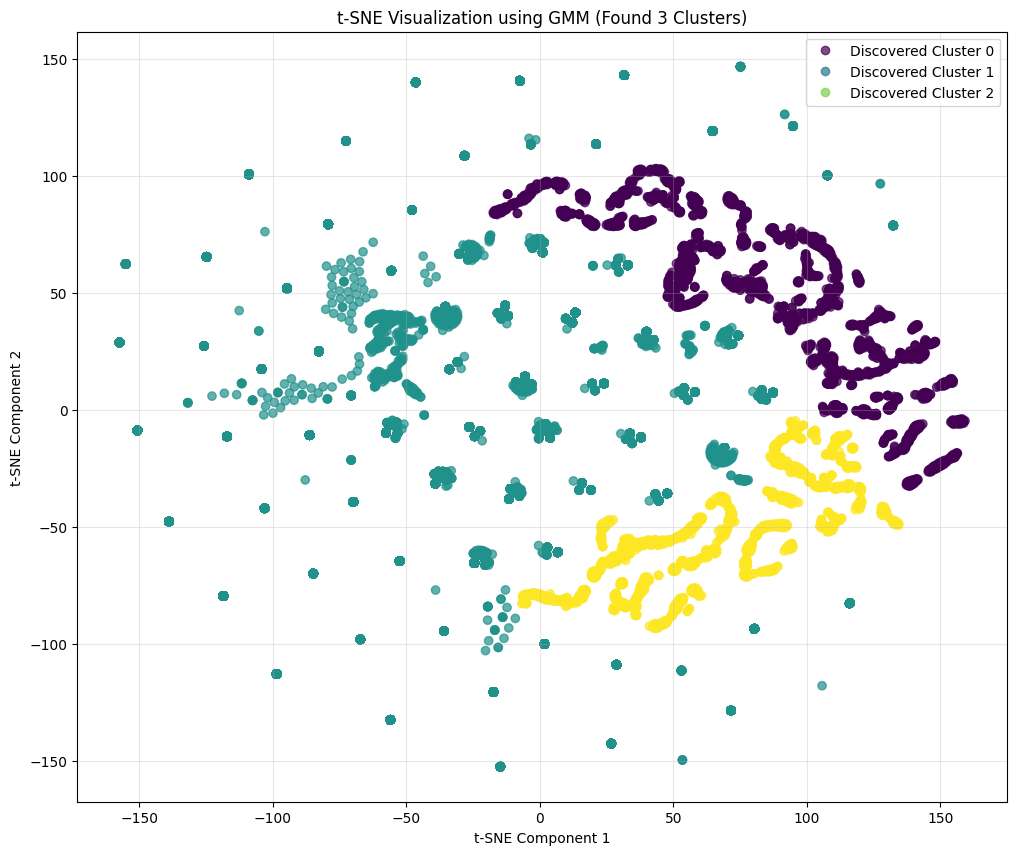


--- Experiment Finished ---


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from collections import defaultdict
import os
import pickle

# Step 6: Use Gaussian Mixture Model with BIC to find the optimal number of clusters
print("4. Running Gaussian Mixture Model (GMM) with BIC to find optimal clusters...")

# Define a range of potential cluster numbers to test
n_components_range = range(2, 16) # Test from 2 to 15 clusters

# Calculate BIC for each number of components
bic_scores = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42, n_init=10)
    gmm.fit(unlabeled_embeddings)
    bic_scores.append(gmm.bic(unlabeled_embeddings))
    print(f"   BIC for {n_components} components: {bic_scores[-1]:.2f}")

# Find the optimal number of clusters (the one with the lowest BIC)
optimal_n_clusters = n_components_range[np.argmin(bic_scores)]
print(f"\n   Optimal number of clusters found via BIC: {optimal_n_clusters}")

# Fit the final GMM with the optimal number of clusters
best_gmm = GaussianMixture(n_components=optimal_n_clusters, random_state=42, n_init=10)
best_gmm.fit(unlabeled_embeddings)
cluster_labels = best_gmm.predict(unlabeled_embeddings)

# Step 7: Visualize the results
print("5. Visualizing the embedding space...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(unlabeled_embeddings)-1))
embeddings_2d = tsne.fit_transform(unlabeled_embeddings)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title(f't-SNE Visualization using GMM (Found {optimal_n_clusters} Clusters)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(handles=scatter.legend_elements(num=optimal_n_clusters)[0], labels=[f'Discovered Cluster {i}' for i in range(optimal_n_clusters)])
plt.grid(True, alpha=0.3)
plt.show()

print("\n--- Experiment Finished ---")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from collections import defaultdict
import random
import os

# --- 1. Configuration ---
# You can tune these parameters
EMBEDDING_DIM = 128     # The size of the learned embedding vector
MARGIN = 1.0            # The margin for the Triplet Loss
LEARNING_RATE = 0.003
BATCH_SIZE = 32
EPOCHS = 200
TEST_SPLIT_SIZE = 0.2   # 20% of data will be used for testing

# --- 2. Data Loading and Preprocessing ---
def load_and_preprocess_data(file_path):
    """
    Loads PDW data from a CSV file and preprocesses it.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        tuple: A tuple containing:
            - pdws_normalized (np.ndarray): Normalized array of PDW features.
            - labels_numeric (np.ndarray): Array of numeric labels.
            - label_mapping (dict): A dictionary mapping numeric labels back to original names.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Error: The file '{file_path}' was not found.")
        
    print(f"Loading data from '{file_path}'...")
    df = pd.read_csv(file_path)

    # Define feature and label columns
    feature_columns = ['PW(µs)','Azimuth(º)','Elevation(º)','Power(dBm)','Freq(MHz)']
    label_column = 'Name'

    # Check for required columns
    for col in feature_columns + [label_column]:
        if col not in df.columns:
            raise ValueError(f"Error: CSV file must contain the column '{col}'.")

    # Extract features
    pdws = df[feature_columns].values.astype(np.float32)

    # Convert string labels to numeric labels
    labels_numeric, unique_labels = pd.factorize(df[label_column])
    label_mapping = {i: name for i, name in enumerate(unique_labels)}
    
    print("   Label mapping created:")
    for numeric_label, string_label in label_mapping.items():
        print(f"   {numeric_label} -> '{string_label}'")

    # Normalize all feature columns
    pdws_normalized = np.copy(pdws)
    for col in range(pdws_normalized.shape[1]):
        mean = pdws_normalized[:, col].mean()
        std = pdws_normalized[:, col].std()
        if std > 0:
            pdws_normalized[:, col] = (pdws_normalized[:, col] - mean) / std
    
    print(f"   Successfully loaded and processed {len(df)} pulses.")
    return pdws_normalized, labels_numeric, label_mapping


# --- 3. Triplet Dataset Class ---
# This custom PyTorch Dataset creates triplets of single PDW vectors on-the-fly.
class TripletPDWDataset(Dataset):
    """
    Custom dataset for generating triplets of single PDW vectors.
    """
    def __init__(self, pdws, labels):
        self.pdws = pdws
        self.labels = labels
        
        # Group indices by label for efficient triplet mining
        self.label_to_indices = defaultdict(list)
        for idx, label in enumerate(labels):
            self.label_to_indices[label].append(idx)
        
        self.labels_set = list(self.label_to_indices.keys())
        if len(self.labels_set) < 2:
            raise ValueError("The dataset must contain at least two different classes to create triplets.")

    def __len__(self):
        return len(self.pdws)

    def __getitem__(self, index):
        # --- Anchor Selection ---
        anchor_idx = index
        anchor_label = self.labels[anchor_idx]
        anchor_pdw = torch.FloatTensor(self.pdws[anchor_idx])

        # --- Positive Selection ---
        # Randomly select another sample from the same class
        positive_idx = random.choice(self.label_to_indices[anchor_label])
        positive_pdw = torch.FloatTensor(self.pdws[positive_idx])

        # --- Negative Selection ---
        # Randomly select a sample from a different class
        negative_label = random.choice([l for l in self.labels_set if l != anchor_label])
        negative_idx = random.choice(self.label_to_indices[negative_label])
        negative_pdw = torch.FloatTensor(self.pdws[negative_idx])

        return anchor_pdw, positive_pdw, negative_pdw

# --- 4. Model Architecture (The Encoder f(x)) ---
# An ANN/MLP-based network to process single PDWs and output an embedding.
class EmitterEncoder(nn.Module):
    """
    ANN/MLP-based encoder to generate embeddings from single PDW vectors.
    """
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(EmitterEncoder, self).__init__()
        # A simple multi-layer perceptron
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
        )

    def forward(self, x):
        embedding = self.net(x)
        # Normalize the embedding to have unit length (improves stability)
        embedding = nn.functional.normalize(embedding, p=2, dim=1)
        return embedding

# --- 5. Triplet Loss Function ---
class TripletLoss(nn.Module):
    """
    Triplet loss function.
    """
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Calculate Euclidean distances
        distance_positive = (anchor - positive).pow(2).sum(1)  # d(a, p)^2
        distance_negative = (anchor - negative).pow(2).sum(1)  # d(a, n)^2
        # Calculate loss
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

# --- 6. Main Execution Block ---
if __name__ == '__main__':
    # !!! IMPORTANT !!!
    # !!! CHANGE THIS PATH TO POINT TO YOUR CSV FILE !!!
    # CSV_FILE_PATH = 'sampledpoints.csv' 
    CSV_FILE_PATH = 'CombinedDeinterleaved.csv' 
    
    print("--- Emitter Classification Training using Siamese Triplet Loss (ANN Version) ---")

    # Step 1: Load and Preprocess Data
    try:
        pdws, labels, label_mapping = load_and_preprocess_data(CSV_FILE_PATH)
    except (FileNotFoundError, ValueError) as e:
        print(e)
        # Create a dummy CSV file for demonstration if the specified one doesn't exist
        print(f"\nCreating a dummy file '{CSV_FILE_PATH}' for demonstration purposes.")
        print("Please replace this with your actual data file.")
        dummy_data = {
            'AOA': np.random.rand(1000) * 360,
            'PW': np.random.rand(1000) * 10e-6,
            'Frequency': 8e9 + np.random.rand(1000) * 1e9,
            'Amplitude': 50 + np.random.rand(1000) * 10,
            'Name': [random.choice(['Emitter_A', 'Emitter_B', 'Emitter_C']) for _ in range(1000)]
        }
        pd.DataFrame(dummy_data).to_csv(CSV_FILE_PATH, index=False)
        pdws, labels, label_mapping = load_and_preprocess_data(CSV_FILE_PATH)

    # Step 2: Split data into Training and Testing sets
    print(f"\n2. Splitting data into {1-TEST_SPLIT_SIZE:.0%} training and {TEST_SPLIT_SIZE:.0%} testing...")
    X_train, X_test, y_train, y_test = train_test_split(
        pdws, labels, test_size=TEST_SPLIT_SIZE, random_state=42, stratify=labels
    )
    print(f"   Training set size: {len(X_train)}")
    print(f"   Testing set size: {len(X_test)}")

    # Step 3: Create Dataset and DataLoader for TRAINING data
    print("\n3. Creating Triplet Dataset and DataLoader for training...")
    train_dataset = TripletPDWDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Step 4: Initialize Model, Loss, and Optimizer
    print("4. Initializing model, loss function, and optimizer...")
    input_dim = pdws.shape[1] 
    model = EmitterEncoder(input_dim=input_dim, hidden_dim=128, embedding_dim=EMBEDDING_DIM)
    criterion = TripletLoss(margin=MARGIN)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Step 5: Training Loop with Loss Tracking
    print(f"5. Starting training for {EPOCHS} epochs...")
    model.train()
    
    # Initialize loss tracking
    epoch_losses = []
    
    for epoch in range(EPOCHS):
        total_loss = 0
        for i, (anchor, positive, negative) in enumerate(train_dataloader):
            optimizer.zero_grad()
            anchor_emb, positive_emb, negative_emb = model(anchor), model(positive), model(negative)
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_dataloader)
        epoch_losses.append(avg_loss)
        print(f"   Epoch [{epoch+1}/{EPOCHS}], Average Loss: {avg_loss:.4f}")

    print("--- Training complete! ---")

    # Step 5.5: Plot Loss Curve
    print("\n5.5. Plotting training loss curve...")
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, EPOCHS + 1), epoch_losses, 'b-', linewidth=2, label='Training Loss')
    plt.title('Training Loss Curve - Triplet Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Step 6: Evaluation
    print("\n6. Evaluating the model on the test set...")
    model.eval()
    with torch.no_grad():
        # A: Generate embeddings for the entire training set to define cluster centroids
        train_embeddings = model(torch.FloatTensor(X_train)).numpy()
        
        # B: Calculate the centroid for each cluster from the training data
        cluster_centroids = defaultdict(list)
        for i, label in enumerate(y_train):
            cluster_centroids[label].append(train_embeddings[i])
        
        for label in cluster_centroids:
            cluster_centroids[label] = np.mean(cluster_centroids[label], axis=0)
            
        # C: Generate embeddings for the test set
        test_embeddings = model(torch.FloatTensor(X_test)).numpy()
        
        # D: Predict the label for each test embedding by finding the closest centroid
        predictions = []
        for test_emb in test_embeddings:
            distances = {label: np.linalg.norm(test_emb - centroid) for label, centroid in cluster_centroids.items()}
            predicted_label = min(distances, key=distances.get)
            predictions.append(predicted_label)
            
        # E: Calculate and print accuracy and classification report
        accuracy = accuracy_score(y_test, predictions)
        print(f"\n   Overall Accuracy on Test Set: {accuracy * 100:.2f}%")
        
        report_labels = sorted(list(label_mapping.keys()))
        report_target_names = [label_mapping[lbl] for lbl in report_labels]
        print("\n   Classification Report:")
        print(classification_report(y_test, predictions, labels=report_labels, target_names=report_target_names))


    # Step 7: Visualization of TEST SET embeddings
    print("\n7. Visualizing the learned embedding space for the TEST SET using t-SNE...")
    # Use t-SNE to reduce dimensionality of test embeddings to 2D for plotting
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_test)-1), n_iter=1000)
    embeddings_2d = tsne.fit_transform(test_embeddings)

    # Plot the results
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, cmap='viridis', alpha=0.7)
    plt.title('t-SNE Visualization of Test Set Emitter Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    
    legend_labels = [label_mapping[i] for i in sorted(label_mapping.keys())]
    plt.legend(handles=scatter.legend_elements(num=len(legend_labels))[0], labels=legend_labels)
    plt.grid(True)
    plt.show()

    print("--- Script finished. ---")